# Emojitranslate project

## Part one - learning to predict emojis from tweets

The following code adapted from the Osinga deep learning cookbook - using the Twitter API to sample EN language tweets that contain exactly one emoji

In [42]:
import random
import twitter
import emoji
# import itertools
import pandas as pd
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#from sklearn.model_selection import train_test_split
from keras import Sequential, optimizers, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
import keras.callbacks
#import json

import os
# import nb_utils
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalMaxPooling1D#, Merge 
from keras.models import Model
from keras.layers.merge import Concatenate, Average

# from gensim.models import Word2Vec

In [43]:
all_tweets = pd.read_csv('data/emojis_homemade.csv')
all_tweets['emoji'].value_counts()

😂        41999
😭        17206
❤        13689
emoji     9718
😍         9350
🔥         8874
🤣         5876
🤔         4587
🙏         4465
😩         4349
💕         4280
😊         4067
🖤         3997
👀         3672
✨         3495
💜         3483
👏         3393
🙄         3267
💀         3067
🎉         2956
🙌         2798
😏         2762
😘         2671
💯         2583
💙         2455
👍         2377
😔         2362
😉         2251
😎         2242
💖         2197
         ...  
📇            1
🚛            1
⚱            1
↕            1
📤            1
🖲            1
🔕            1
💹            1
🗃            1
📒            1
🕠            1
🤼            1
🕕            1
📏            1
👷            1
🕍            1
⛎            1
🀄            1
🧘            1
🏣            1
🛥            1
🛋            1
➿            1
⏸            1
🏨            1
🚾            1
🔚            1
🗄            1
➗            1
💇            1
Name: emoji, Length: 1065, dtype: int64

In [44]:
all_tweets.shape

(336011, 3)

In [45]:
all_tweets.head

<bound method NDFrame.head of         Unnamed: 0                                               text emoji
0              0.0  RT @mydear_bangtan: [VID] 181023 - Foi adicion...     ©
1              1.0  RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...     💫
2              2.0  RT @TrendsPrabhas: Now you are watching Indian...     😎
3              3.0                                    dats for keeps      💛
4              4.0  RT @xruiztru: WHO ARMS THE SAUDIS?\n\n  🇺🇸US 5...     🏳
5              5.0  RT @xxxfreaknasty2: interracial couple go at i...     🌝
6              6.0               @Eric_Deshaun Holy shit no I think.      😩
7              7.0     RT @fanmutuals: army, follow who retweet this      👑
8              8.0  RT @_Simplykpop: Simply K-Pop harddrive dump\n...     🤩
9              9.0  Happy birthday nellie @thelittlegend, hope you...     ❤
10            10.0  RT @montparnasty: "I have passed through fire"...     💕
11            11.0  RT @Jason_Mckeown: Look how empty Vall

In [46]:
tweets = all_tweets.groupby('emoji').filter(lambda c:len(c) > 1000)
tweets['emoji'].value_counts()

😂        41999
😭        17206
❤        13689
emoji     9718
😍         9350
🔥         8874
🤣         5876
🤔         4587
🙏         4465
😩         4349
💕         4280
😊         4067
🖤         3997
👀         3672
✨         3495
💜         3483
👏         3393
🙄         3267
💀         3067
🎉         2956
🙌         2798
😏         2762
😘         2671
💯         2583
💙         2455
👍         2377
😔         2362
😉         2251
😎         2242
💖         2197
         ...  
🙃         1697
🗣         1682
🤪         1641
😢         1586
😤         1553
☺         1498
🤗         1450
©         1447
🤧         1437
😒         1396
💥         1391
✌         1377
😌         1325
😫         1308
💗         1305
💔         1303
😈         1276
☹         1256
🙂         1254
👉         1241
🤝         1237
🎶         1227
🤩         1190
💚         1163
😆         1152
➡         1073
😋         1061
💞         1044
💓         1027
▶         1022
Name: emoji, Length: 72, dtype: int64

In [47]:
tweets['emoji'].value_counts()[0]/sum(tweets['emoji'].value_counts())

0.17238067484536676

In [48]:
max(tweets['text'], key=lambda t:len(t))

'RT @DingDongLive: LMAO  @TexasEDMFamily\n@FreakyDeakyFam\nGrab my hard/hybrid trap mix&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt; https://t.co/34rcxAVbgk https://t.co/ArQeh23L…'

In [49]:
chars = list(sorted(set(chain(*tweets['text']))))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
max_sequence_len = max(len(x) for x in tweets['text'])

emojis = list(sorted(set(tweets['emoji'])))
emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
emojis[:10]

#train_tweets, test_tweets = train_test_split(tweets, test_size=0.1)

['emoji', '©', '‼', '▶', '☹', '☺', '♥', '✌', '✨', '❤']

Currently we've collected quite a lot of tweet data, so to speed up the prototyping of the model we're going to create a train/dev/test datasets of 10,000 tweets each.

In [50]:
train_tweets = tweets[0:10000]
dev_tweets = tweets[10000:20000]
test_tweets = tweets[20000:30000]


# !! Temp! Try on much bigger dataset
#train_tweets = tweets[0:100000] # 100000 tweets
#dev_tweets = tweets[100000:110000]
#test_tweets = tweets[110000:120000]



In [51]:
#def data_generator(tweets, batch_size):
#    while True:
#        if batch_size is None:
#            batch = tweets
#            batch_size = batch.shape[0]
#        else:
#            batch = tweets.sample(batch_size)
#        X = np.zeros((batch_size, max_sequence_len, len(chars)))
#        y = np.zeros((batch_size,))
#        for row_idx, (_, row) in enumerate(batch.iterrows()):
#            y[row_idx] = emoji_to_idx[row['emoji']]
#            for ch_idx, ch in enumerate(row['text']):
#                X[row_idx, ch_idx, char_to_idx[ch]] = 1
#        yield X, y
#
#next(data_generator(tweets, 10))

In [52]:
#def create_char_cnn_model(num_chars, max_sequence_len, num_labels):
#    char_input = Input(shape=(max_sequence_len, num_chars), name='char_cnn_input')
#    
#    conv_1x = Conv1D(128, 6, activation='relu', padding='valid')(char_input)
#    max_pool_1x = MaxPooling1D(4)(conv_1x)
#    conv_2x = Conv1D(256, 6, activation='relu', padding='valid')(max_pool_1x)
#    max_pool_2x = MaxPooling1D(4)(conv_2x)

#    flatten = Flatten()(max_pool_2x)
#    dense = Dense(128, activation='relu')(flatten)
#    preds = Dense(num_labels, activation='softmax', name='char_cnn_predictions')(dense)

#    model = Model(char_input, preds)
#    model.compile(loss='sparse_categorical_crossentropy',
#                  optimizer='rmsprop',
#                  metrics=['acc'])
#    return model

#char_cnn_model = create_char_cnn_model(len(char_to_idx), max_sequence_len, len(emojis))
#char_cnn_model.summary()

In [53]:
#early = keras.callbacks.EarlyStopping(monitor='loss',
#                              min_delta=0.03,
#                              patience=2,
#                              verbose=1, mode='auto')

#checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_cnn.h5',
#                                             monitor='val_acc',
#                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                         histogram_freq=1,
#                                         embeddings_freq=1)

#BATCH_SIZE = 512
#char_cnn_model.fit_generator(
#    data_generator(train_tweets, batch_size=BATCH_SIZE),
#    validation_data = data_generator(dev_tweets, batch_size=BATCH_SIZE),
#    validation_steps=int(dev_tweets.shape[0]/BATCH_SIZE),
#    epochs=5,
#    steps_per_epoch=len(train_tweets) / BATCH_SIZE,
#    verbose=1, # was: verbose=2
#    callbacks=[early, checkpoint]
#)

In [54]:
#pd.options.display.max_colwidth = 128
#inspect_tweets = dev_tweets.sample(100)
#predicted = char_cnn_model.predict_generator(data_generator(inspect_tweets, batch_size=None), steps=1)
#show = pd.DataFrame({
#    'text': inspect_tweets['text'],
#    'true': inspect_tweets['emoji'],
#    'pred': [emojis[np.argmax(x)] for x in predicted],
#})
#show = show[['text', 'true', 'pred']]
#show.head(10)

# Simple neural network - single Dense layer

Benchmark performance with the simplest neural network we can get

Let's divide up the train/dev/test sets so we're not relying on a generator

In [55]:
x_train = train_tweets["text"]
y_train = np.asarray(train_tweets["emoji"])
x_dev = dev_tweets["text"]
y_dev = np.asarray(dev_tweets["emoji"])
x_test = test_tweets["text"]
y_test = np.asarray(test_tweets["emoji"])

all_emojis = np.concatenate((y_train, y_dev, y_test), axis=0)

emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
#emojis[:10]

all_emojis_idx = np.zeros(all_emojis.shape[0])

for i in range (all_emojis.shape[0]):
    all_emojis_idx[i] = emoji_to_idx[all_emojis[i]]    

all_emojis_one_hot = to_categorical (all_emojis_idx)
    
y_train_idx = all_emojis_one_hot[0:10000,:]
y_dev_idx = all_emojis_one_hot[10000:20000,:]
y_test_idx = all_emojis_one_hot[20000:30000,:]


# Temp!
#y_train_idx = all_emojis_one_hot[0:100000,:]
#y_dev_idx = all_emojis_one_hot[100000:110000,:]
#y_test_idx = all_emojis_one_hot[110000:120000,:]

In [56]:
# y_train_idx[0:10]

Now let's start by one-hot encoding the text samples

In [57]:
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts (x_train)

#x_train_sequences = tokenizer.texts_to_sequences(x_train)
#x_dev_sequences = tokenizer.texts_to_sequences(x_dev)
#x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_one_hot = tokenizer.texts_to_matrix(x_train, mode='binary')
x_dev_one_hot = tokenizer.texts_to_matrix(x_dev, mode='binary')
x_test_one_hot = tokenizer.texts_to_matrix(x_test, mode='binary')




# remember to pad sequences

In [58]:
x_train_one_hot.shape

(10000, 1000)

In [59]:
y_train_idx.shape

(10000, 72)

# A linear classifier

As a performance baseline for more complex models, it's instructive to see how well we can do with just a linear classifier with no hidden layer. With 64 hidden units trained on 10,000 training examples, we're able to get up to about 38% accuracy on the validation set. A lower learning rate slows down the learning (although it's still very fast) but doesn't appear to do any better in terms of final accuracy before the model starts overfitting. 

In [60]:
y_dev_idx.shape

(10000, 72)

In [61]:
output_size = y_dev_idx.shape[1] # around 64 units for 10,000 tweets

model = Sequential()
model.add(Dense(output_size, activation='softmax', input_shape=(1000,))) 
model.compile(optimizer=optimizers.RMSprop(lr = 0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    verbose=2)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
 - 1s - loss: 3.8701 - acc: 0.2371 - val_loss: 3.6482 - val_acc: 0.2786
Epoch 2/20
 - 0s - loss: 3.3552 - acc: 0.3150 - val_loss: 3.4394 - val_acc: 0.3044
Epoch 3/20
 - 0s - loss: 3.0830 - acc: 0.3386 - val_loss: 3.3187 - val_acc: 0.3179
Epoch 4/20
 - 0s - loss: 2.8727 - acc: 0.3661 - val_loss: 3.2288 - val_acc: 0.3286
Epoch 5/20
 - 0s - loss: 2.6924 - acc: 0.3920 - val_loss: 3.1575 - val_acc: 0.3351
Epoch 6/20
 - 0s - loss: 2.5358 - acc: 0.4111 - val_loss: 3.1014 - val_acc: 0.3453
Epoch 7/20
 - 0s - loss: 2.3970 - acc: 0.4370 - val_loss: 3.0584 - val_acc: 0.3478
Epoch 8/20
 - 0s - loss: 2.2745 - acc: 0.4555 - val_loss: 3.0258 - val_acc: 0.3608
Epoch 9/20
 - 0s - loss: 2.1653 - acc: 0.4766 - val_loss: 3.0010 - val_acc: 0.3656
Epoch 10/20
 - 0s - loss: 2.0679 - acc: 0.4955 - val_loss: 2.9832 - val_acc: 0.3676
Epoch 11/20
 - 0s - loss: 1.9811 - acc: 0.5140 - val_loss: 2.9719 - val_acc: 0.3673
Epoch 12/20
 - 0s - loss: 1.9030 - 

In [62]:
import matplotlib.pyplot as plt

def plot_train_history(history): 

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot (epochs, acc, 'bo', label='Training acc')
    plt.plot (epochs, val_acc, 'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

best validation accuracy:  0.3716


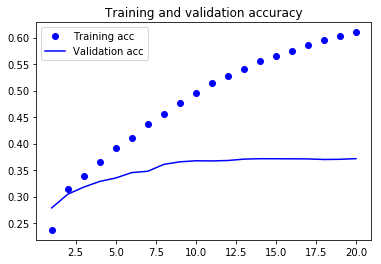

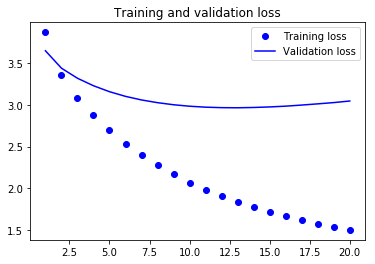

In [63]:
print ("best validation accuracy: ", max(history.history['val_acc']))
plot_train_history(history)

# Shallow neural network
A simple shallow neural network with a layer of hidden units

128 hidden units gets us up to 39% accuracy

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 86us/step - loss: 4.0160 - acc: 0.2220 - val_loss: 3.8034 - val_acc: 0.2583
Epoch 2/10
10000/10000 [==============================] - 0s 45us/step - loss: 3.6105 - acc: 0.2677 - val_loss: 3.5791 - val_acc: 0.2778
Epoch 3/10
10000/10000 [==============================] - 0s 46us/step - loss: 3.4034 - acc: 0.2955 - val_loss: 3.4516 - val_acc: 0.3044
Epoch 4/10
10000/10000 [==============================] - 0s 41us/step - loss: 3.2381 - acc: 0.3267 - val_loss: 3.3351 - val_acc: 0.3190
Epoch 5/10
10000/10000 [==============================] - 0s 46us/step - loss: 3.0869 - acc: 0.3495 - val_loss: 3.2315 - val_acc: 0.3307
Epoch 6/10
10000/10000 [==============================] - 0s 47us/step - loss: 2.9463 - acc: 0.3667 - val_loss: 3.1374 - val_acc: 0.3389
Epoch 7/10
10000/10000 [==============================] - 0s 47us/step - loss: 2.8191 - acc: 0.3817 - val_loss: 3.0579 - val_acc

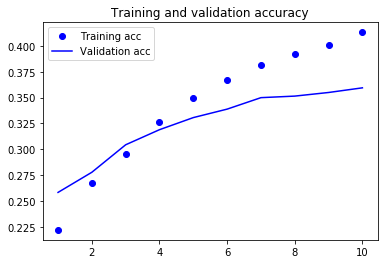

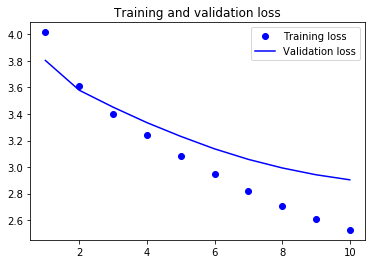

best validation accuracy:  0.3595000002384186


In [64]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(1000,)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 10,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx))

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

# Two layers of hidden units
A slight improvement over one layer of hidden units (<1%)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 125us/step - loss: 4.1550 - acc: 0.1835 - val_loss: 3.8672 - val_acc: 0.2626
Epoch 2/20
10000/10000 [==============================] - 1s 77us/step - loss: 3.6252 - acc: 0.2850 - val_loss: 3.5774 - val_acc: 0.3019
Epoch 3/20
10000/10000 [==============================] - 1s 77us/step - loss: 3.3096 - acc: 0.3382 - val_loss: 3.4011 - val_acc: 0.3238
Epoch 4/20
10000/10000 [==============================] - 1s 78us/step - loss: 3.0979 - acc: 0.3690 - val_loss: 3.2835 - val_acc: 0.3331
Epoch 5/20
10000/10000 [==============================] - 1s 79us/step - loss: 2.9419 - acc: 0.3879 - val_loss: 3.2092 - val_acc: 0.3401
Epoch 6/20
10000/10000 [==============================] - 1s 76us/step - loss: 2.8261 - acc: 0.4048 - val_loss: 3.1701 - val_acc: 0.3466
Epoch 7/20
10000/10000 [==============================] - 1s 78us/step - loss: 2.7218 - acc: 0.4219 - val_loss: 3.1180 - val_ac

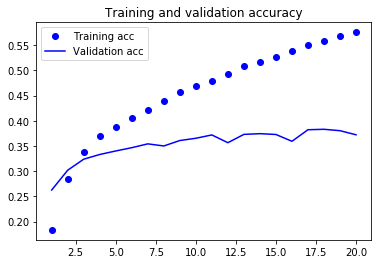

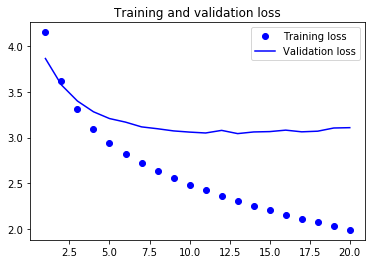

best validation accuracy:  0.3830999997138977


In [65]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(1000,)))
model.add(Dense(128, activation='relu', 
                kernel_regularizer = regularizers.l2(0.0025)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx))

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## Two layer network with dropout and regularization

Takes longer to train than the network with neither. Some improvements in accuracy but it's a bit marginal.

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 2s 155us/step - loss: 4.1840 - acc: 0.1693 - val_loss: 3.9021 - val_acc: 0.1981
Epoch 2/20
10000/10000 [==============================] - 1s 90us/step - loss: 3.7801 - acc: 0.2431 - val_loss: 3.6576 - val_acc: 0.2692
Epoch 3/20
10000/10000 [==============================] - 1s 82us/step - loss: 3.5358 - acc: 0.2771 - val_loss: 3.4836 - val_acc: 0.2998
Epoch 4/20
10000/10000 [==============================] - 1s 87us/step - loss: 3.3546 - acc: 0.3049 - val_loss: 3.3658 - val_acc: 0.3158
Epoch 5/20
10000/10000 [==============================] - 1s 82us/step - loss: 3.2246 - acc: 0.3277 - val_loss: 3.2810 - val_acc: 0.3259
Epoch 6/20
10000/10000 [==============================] - 1s 86us/step - loss: 3.1203 - acc: 0.3461 - val_loss: 3.2223 - val_acc: 0.3282
Epoch 7/20
10000/10000 [==============================] - 1s 84us/step - loss: 3.0263 - acc: 0.3617 - val_loss: 3.1710 - val_ac

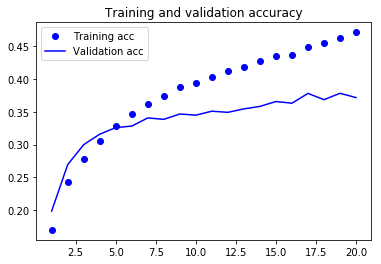

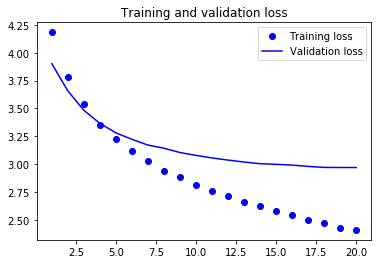

In [66]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(1000,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu',
                kernel_regularizer = regularizers.l2(0.002)))
model.add(Dropout(0.4))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx))

plot_train_history(history)

In [41]:
print ("best validation accuracy: ", max(history.history['val_acc']))

best validation accuracy:  0.37530000014305115


# Embedding Layer

First of all, let's try just an embedding layer, into a classifier

In [73]:
x_train[0]

'RT @mydear_bangtan: [VID] 181023 - Foi adicionada a letra “D” no outdoor misterioso do #BTS em Hollywood.\nFormando: BTS AND... \n\n ILOVEPAR…'

In [100]:
# Tokenize the tweets into lists of words

maxlen = 20

def convert_to_sequences(tweet_text, tokenizer, maxlen=20):
    tweet_sequence = np.asarray(tokenizer.texts_to_sequences(tweet_text))
    padded = pad_sequences (tweet_sequence, maxlen=maxlen)
    return (padded)

x_train_sequences = convert_to_sequences(x_train, tokenizer, maxlen=20)
x_dev_sequences = convert_to_sequences(x_dev, tokenizer, maxlen=20)
x_test_sequences = convert_to_sequences(x_test, tokenizer, maxlen=20)

In [102]:
n_output_classes = y_dev_idx.shape[1]

def simple_embedding_model(n_output_classes, max_sequence_length = 20):

    model = Sequential()

    # 8-dimensional embedding layer for 1,000 words
    model.add(Embedding(1000, 8, input_length = max_sequence_length), name="embedding") 

    # flattens 3D tensor of embeddings into 2D tensor of shape (samples, maxlen * 8)
    model.add(Flatten()) 

    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

Train on 10000 samples, validate on 10000 samples
Epoch 1/40
10000/10000 [==============================] - 1s 73us/step - loss: 4.1913 - acc: 0.1699 - val_loss: 4.1123 - val_acc: 0.2051
Epoch 2/40
10000/10000 [==============================] - 0s 24us/step - loss: 4.0272 - acc: 0.2045 - val_loss: 3.9486 - val_acc: 0.2064
Epoch 3/40
10000/10000 [==============================] - 0s 24us/step - loss: 3.8612 - acc: 0.2050 - val_loss: 3.8022 - val_acc: 0.2061
Epoch 4/40
10000/10000 [==============================] - 0s 23us/step - loss: 3.7292 - acc: 0.2043 - val_loss: 3.7045 - val_acc: 0.2082
Epoch 5/40
10000/10000 [==============================] - 0s 22us/step - loss: 3.6487 - acc: 0.2028 - val_loss: 3.6537 - val_acc: 0.2055
Epoch 6/40
10000/10000 [==============================] - 0s 22us/step - loss: 3.6031 - acc: 0.2012 - val_loss: 3.6243 - val_acc: 0.2074
Epoch 7/40
10000/10000 [==============================] - 0s 21us/step - loss: 3.5668 - acc: 0.2040 - val_loss: 3.5980 - val_acc

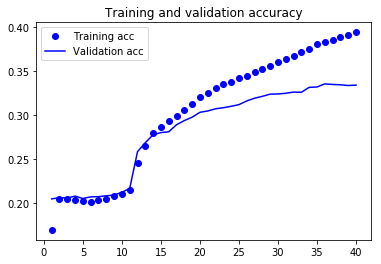

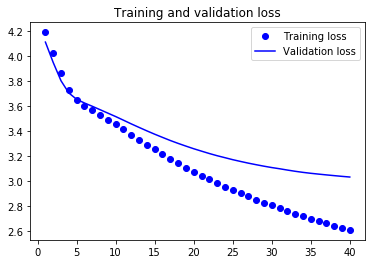

In [107]:
model = simple_embedding_model(n_output_classes, maxlen)    

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.03,
                              patience=2,
                              verbose=1, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_embedding.h5',
                                             monitor='val_acc',
                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                          #write_grads=1,
#                                          #histogram_freq=1,
#                                          embeddings_freq=1,
#                                          embeddings_data=,
#                                          embedding_layer_names='embedding')

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 40,
                     batch_size = 512,
                     verbose=1)
                     #callbacks=[early, checkpoint, tensorboard])

plot_train_history(history)